# Bagging Model

This notebook trains and evaluates a Bagging Regressor model to reduce the variance observed in a single Decision Tree model.

## 0. Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt

## 1. Load Processed Data

In [2]:
DATA_PATH = "../data/processed/flight_prices_processed.csv"
df = pd.read_csv(DATA_PATH)

df.shape, df.columns
df.head()

,Airline,Source,Destination,Total_Stops,Price,Price_USD,Duration_min,Journey_day,Journey_month,Dep_hour,Dep_min,Arr_hour,Arr_min
0,IndiGo,Banglore,New Delhi,0,3897,46.764,170,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,2,7662,91.944,445,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2,13882,166.584,1140,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1,6218,74.616,325,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1,13302,159.624,285,1,3,16,50,21,35


## 2. Define Features and Target Variable

In [3]:
target = "Price_USD"

X = df.drop(columns=["Price_USD", "Price"], errors="ignore")
y = df[target]

## 3. Train/Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## 4. Preprocessing Pipeline

In [5]:
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median"))
        ]), num_cols),
    ],
    remainder="drop",
)

## 5. Baseline Bagging Regressor

In [6]:
base_tree = DecisionTreeRegressor(random_state=123)

bag = BaggingRegressor(
    estimator=base_tree,
    n_estimators=300,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=123
)

model = Pipeline([
    ("preprocess", preprocess),
    ("bag", bag)
])

model.fit(X_train, y_train)

oob_r2 = model.named_steps["bag"].oob_score_
print(f"OOB R^2 (Bagging): {oob_r2:.4f}")

pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae = mean_absolute_error(y_test, pred)
r2  = r2_score(y_test, pred)

print({"rmse": rmse, "mae": mae, "r2": r2})

OOB R^2 (Bagging): 0.8069
{'rmse': np.float64(23.548054424519936), 'mae': 14.197257871674738, 'r2': 0.80557398926395}


## 6. Optimal Number of Trees via OOB

In [7]:
base_tree_limited = DecisionTreeRegressor(
    max_depth=10,
    min_samples_split=5,
    random_state=123
)

n_trees_range = list(range(50, 501, 50))
oob_errors = []

for n_trees in n_trees_range:
    tmp = Pipeline([
        ("preprocess", preprocess),
        ("bag", BaggingRegressor(
            estimator=base_tree_limited,
            n_estimators=n_trees,
            oob_score=True,
            bootstrap=True,
            n_jobs=-1,
            random_state=123
        ))
    ])
    tmp.fit(X_train, y_train)

    oob_r2 = tmp.named_steps["bag"].oob_score_
    oob_error = 1 - oob_r2
    oob_errors.append((n_trees, oob_error))

    print(f"Finished training {n_trees} trees | OOB R2 = {oob_r2:.4f}")

oob_df = pd.DataFrame(oob_errors, columns=["n_trees", "oob_error"])
oob_df

Finished training 50 trees | OOB R2 = 0.8218
Finished training 100 trees | OOB R2 = 0.8243
Finished training 150 trees | OOB R2 = 0.8239
Finished training 200 trees | OOB R2 = 0.8236
Finished training 250 trees | OOB R2 = 0.8238
Finished training 300 trees | OOB R2 = 0.8237
Finished training 350 trees | OOB R2 = 0.8235
Finished training 400 trees | OOB R2 = 0.8241
Finished training 450 trees | OOB R2 = 0.8241
Finished training 500 trees | OOB R2 = 0.8241


,n_trees,oob_error
0,50,0.178162
1,100,0.175663
2,150,0.176147
3,200,0.176377
4,250,0.176155
5,300,0.176293
6,350,0.176480
7,400,0.175932
8,450,0.175927
9,500,0.175890


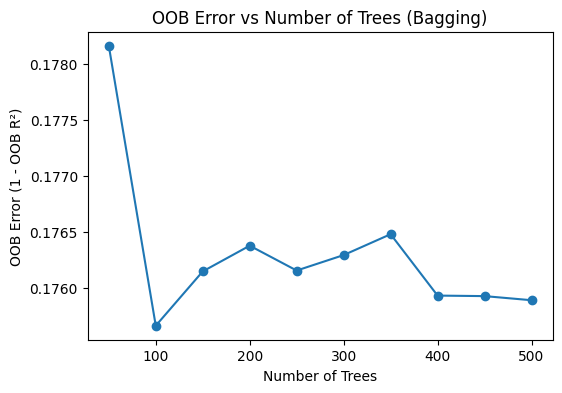

Selected n_trees = 100 with OOB Error = 0.1757


In [8]:
plt.figure(figsize=(6,4))
plt.plot(oob_df["n_trees"], oob_df["oob_error"], marker="o")
plt.xlabel("Number of Trees")
plt.ylabel("OOB Error (1 - OOB R²)")
plt.title("OOB Error vs Number of Trees (Bagging)")
plt.show()

best_row = oob_df.loc[oob_df["oob_error"].idxmin()]
best_n_trees = int(best_row["n_trees"])
print(f"Selected n_trees = {best_n_trees} with OOB Error = {best_row['oob_error']:.4f}")

## 7. Final Bagging Model

In [9]:
final_model = Pipeline([
    ("preprocess", preprocess),
    ("bag", BaggingRegressor(
        estimator=base_tree_limited,
        n_estimators=best_n_trees,
        oob_score=True,
        bootstrap=True,
        n_jobs=-1,
        random_state=123
    ))
])

final_model.fit(X_train, y_train)

pred = final_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mae  = mean_absolute_error(y_test, pred)
r2   = r2_score(y_test, pred)
oob_r2_final = final_model.named_steps["bag"].oob_score_

print({"rmse": rmse, "mae": mae, "r2": r2, "oob_r2": oob_r2_final})

{'rmse': np.float64(22.636778630452717), 'mae': 14.800772764445806, 'r2': 0.8203308342784922, 'oob_r2': 0.8243374023094403}


## 8. Model Evaluation

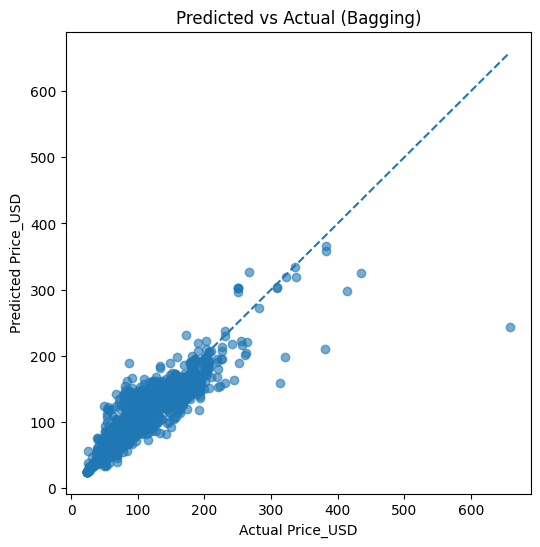

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, pred, alpha=0.6)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual Price_USD")
plt.ylabel("Predicted Price_USD")
plt.title("Predicted vs Actual (Bagging)")
plt.show()

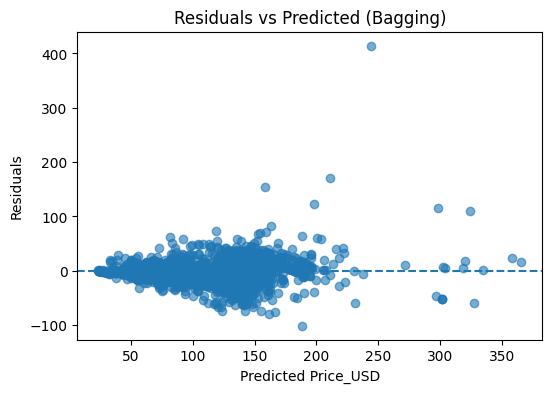

In [11]:
residuals = y_test - pred
plt.figure(figsize=(6,4))
plt.scatter(pred, residuals, alpha=0.6)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Price_USD")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Bagging)")
plt.show()

## 9. Feature Importance Analysis

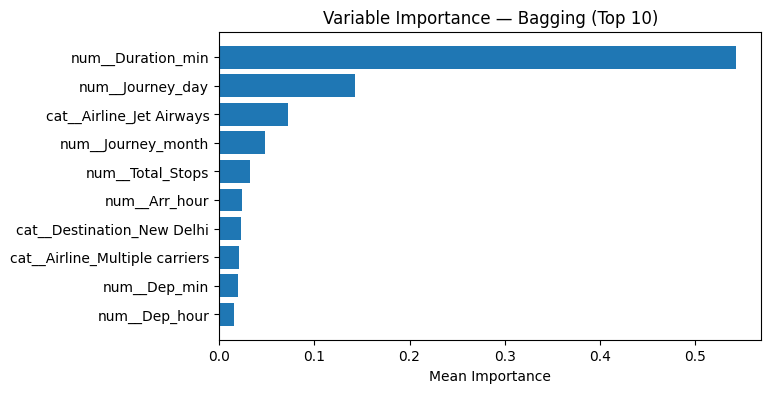

In [12]:
pre_fit = preprocess.fit(X_train)
feature_names = pre_fit.get_feature_names_out()
n_features = len(feature_names)

bag_est = final_model.named_steps["bag"]

global_importance = np.zeros(n_features, dtype=float)
num_used = 0

has_feature_subsampling = hasattr(bag_est, "estimators_features_") and bag_est.estimators_features_ is not None

for i, est in enumerate(bag_est.estimators_):
    if not hasattr(est, "feature_importances_"):
        continue

    fi = est.feature_importances_

    if has_feature_subsampling:
        feats_idx = bag_est.estimators_features_[i]
        tmp = np.zeros(n_features, dtype=float)
        tmp[feats_idx] = fi
        global_importance += tmp
    else:
        global_importance += fi

    num_used += 1

global_importance /= max(num_used, 1)

imp_df = (
    pd.DataFrame({"feature": feature_names, "importance": global_importance})
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

top_k = 10
imp_top = imp_df.head(top_k).sort_values("importance")

plt.figure(figsize=(7,4))
plt.barh(imp_top["feature"], imp_top["importance"])
plt.title(f"Variable Importance — Bagging (Top {top_k})")
plt.xlabel("Mean Importance")
plt.show()


## 10. Example Prediction

In [13]:
new_flight = pd.DataFrame([{
    "Airline": "IndiGo",
    "Source": "Delhi",
    "Destination": "Cochin",
    "Total_Stops": 1,
    "Duration_min": 155,
    "Journey_day": 12,
    "Journey_month": 11,
    "Dep_hour": 15,
    "Dep_min": 25,
    "Arr_hour": 17,
    "Arr_min": 40
}])

pred_new = final_model.predict(new_flight)[0]
print(f"Predicted price (USD): {pred_new:.2f}")

Predicted price (USD): 50.40


## 11. Summary

- OOB error was tracked to select an appropriate number of estimators.
- The final ensemble improves stability while maintaining interpretability through aggregated feature importance.